<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/pix2pix_vs_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook para comparar resultados de algoritmo Pix2Pix y autoencoder

## Librerias

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

## Rutas

In [2]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/imagenes_ndvi/'

# Ruta de salida
OUTPATH = PATH + '/imagenes_segmentadas/'

# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

# Ruta modelo Pix2pix
p2p = PATH + '/pix2pixmodel20211030.h5'

# Ruta modelo Autoencoder
auc = PATH + '/autoencoder20211030.h5'

# Lista de imagenes
imgurls = !ls -1 "{INPATH}"

## Organizando dataset

In [3]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]
 print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 3511 
 Entrenamiento: 2809 
 Testeo: 702 


In [4]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
# Reescalar imagenes
def resize(inimg,tgimg, height,width):
    inimg = tf.image.resize(inimg,[height,width])
    tgimg = tf.image.resize(tgimg,[height,width])

    return inimg,tgimg

# Normalizar el rango [-1, +1] la imagen
def normalize(inimg,tgimg):
    inimg = (inimg/127.5)-1
    tgimg = (tgimg/127.5)-1

    return inimg,tgimg

def random_jitter(inimg,tgimg):
    inimg,tgimg = resize(inimg,tgimg,286,286)

    stacked_image = tf.stack([inimg,tgimg],axis=0)
    croppped_image = tf.image.random_crop(stacked_image,size=[2,IMG_WIDTH,IMG_HEIGHT,3])

    inimg,tgimg = croppped_image[0], croppped_image[1]

    if tf.random.uniform(())>0.5:
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)

    return inimg,tgimg

def load_image(filename, augment=False):
    tg_name=tf.strings.regex_replace(filename, "ndvi", "label")
    inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + '/' + filename)),tf.float32)
    tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(OUTPATH + '/' + tg_name)),tf.float32)
    
    inimg, tgimg = resize(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT)
    
    if augment:
        inimg,tgimg = random_jitter(inimg,tgimg)
    
    inimg,tgimg = normalize(inimg,tgimg)
    return inimg,tgimg

In [5]:
def leer_imagen(path):
    dim = (256,256)
    im = cv2.imread(path)
    im_r = cv2.resize(im,dim)
    return im_r
    
def load_data(urls,path):
    im_s = np.empty((1, 256,256,3))
    im_aux = np.empty((1, 256,256,3))
    cont=0
    for url in urls:
        im = leer_imagen(path + url)
        if cont == 0:
            im_s[0,...] = im
            cont +=1
        else:
            im_aux[0,...] = im
            im_s = np.append(im_s,im_aux,axis=0)
    if cont %100 ==0:
        print(cont)
    return im_s

In [6]:
x = load_data(ts_urls,INPATH)
x.shape

(702, 256, 256, 3)

In [7]:
tg_ts_urls = []
for t in ts_urls:
    tg_ts_urls.append(t.replace('ndvi','label'))

In [8]:
y = load_data(tg_ts_urls,OUTPATH)
y.shape

(702, 256, 256, 3)

## Cargar modelos

In [9]:
try:
    p2p_model = load_model(p2p)
    auc_model = load_model(auc)
    print('modelos cargados exitosamente')
except:
    print('No fue posible cargar los modelos')

modelos cargados exitosamente


## Prueba de carga

In [10]:
def auc_predict(imagen):
    imagen = imagen/255
    return auc_model.predict(imagen)
def p2p_predict(i):
    entrada,etiqueta =load_image(ts_urls[i])
    aux=np.zeros([1,256,256,3])
    salida2 = np.zeros([1,256,256,3])
    aux[0,...]=entrada # el modelo necesita una entrada de 4 dimensiones (examples,rows,columns,caps)
    salida = p2p_model(aux,training=True)
    salida2[...,0] = salida[...,2]
    salida2[...,1] = salida[...,1]
    salida2[...,2] = salida[...,0]
    return salida2

In [11]:
imagen = 500
entrada = x[imagen:imagen+1,...]
salida = y[imagen:imagen+1,...]
auc_p = auc_predict(entrada)
p2p_p = p2p_predict(imagen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


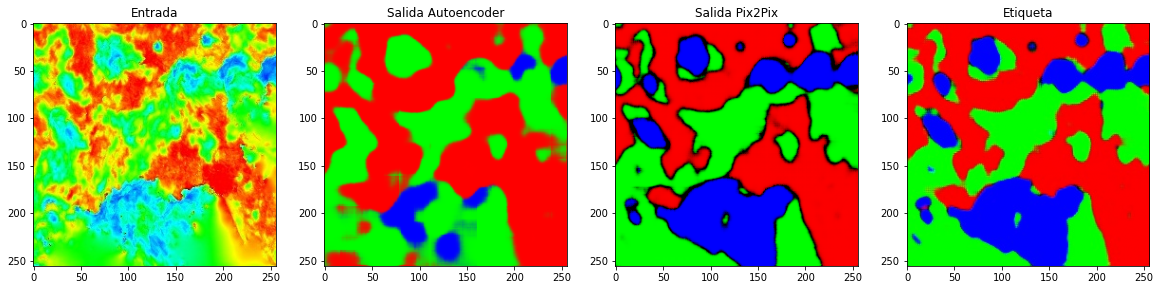

In [13]:
plt.figure(figsize=(20,12))

plt.subplot(141)
plt.title('Entrada')
plt.imshow(np.squeeze(entrada)/255)

plt.subplot(142)
plt.title('Salida Autoencoder')
plt.imshow(np.squeeze(auc_p))

plt.subplot(143)
plt.title('Salida Pix2Pix')
plt.imshow(np.squeeze(p2p_p))

plt.subplot(144)
plt.title('Etiqueta')
plt.imshow(np.squeeze(salida)/255)

plt.show()



## Metricas de desempeño

### Actualizar libreria para metricas

In [14]:
!pip install -U scikit-image

     |████████████████████████████████| 29.2 MB 79 kB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [15]:
from skimage import metrics

### Funciones para calcular medidas

In [78]:
def calcular_metricas_auc(original,pred):
    label = original[0,...]/255
    label = np.around(label)
    #label = pred[0,...]
    test = pred[0,...]
    #ct = metrics.contingency_table(label,test)
    #hd = metrics.hausdorff_distance(label,test)
    #hp = metrics.hausdorff_pair(label,test)
    mse = metrics.mean_squared_error(label,test)
    #nrm = metrics.normalized_root_mse(label,test)
    #psnr = metrics.peak_signal_noise_ratio(label,test)
    ss = metrics.structural_similarity(label,test, multichannel=True)
    return mse,ss
#calcular_metricas_auc(original=salida,pred=auc_p)


In [115]:
def calcular_metricas_p2p(original,pred):
    mse = metrics.mean_squared_error(np.squeeze(original)/255,(np.squeeze(pred)+1)/2)
    ss = metrics.structural_similarity(np.squeeze(original)/255,(np.squeeze(pred)+1)/2, multichannel=True)
    #ct = metrics.contingency_table(label,test)
    #hd = metrics.hausdorff_distance(label,test)
    #hp = metrics.hausdorff_pair(label,test)    
    #nrm = metrics.normalized_root_mse(np.squeeze(salida),np.squeeze(test))
    #psnr = metrics.peak_signal_noise_ratio(np.squeeze(salida),np.squeeze(test))
    
    return mse,ss
#calcular_metricas_p2p(original=salida,pred=p2p_p)

In [116]:
def contar_areas(img):
    if img.min()<0:
        img = (img+1)/2
    elif img.max()>10:
        img = img/255
    a = np.around(img)[0,...]
    c0 = a[...,0]
    c1 = a[...,1]
    c2 = a[...,2]
    return np.sum(c0),np.sum(c1),np.sum(c2)

## Obteniendo métricas

In [117]:
hd_auc = []
mse_auc = []
nrm_auc = []
psnr_auc = []
ss_auc = []
c0_auc = []
c1_auc = []
c2_auc = []

hd_p2p = []
mse_p2p = []
nrm_p2p = []
psnr_p2p = []
ss_p2p = []
c0_p2p = []
c1_p2p = []
c2_p2p = []

for i in range(x.shape[0]):
#for i in range(500,510):
    imagen = i
    entrada = x[imagen:imagen+1,...]
    salida = y[imagen:imagen+1,...]
    area_etiqueta = contar_areas(salida)

    # obtener estimaciones de modelos
    auc_p = auc_predict(entrada)
    p2p_p = p2p_predict(imagen)
    p2p_p = np.around(p2p_p)

    # Contar el area de las imagenes estimadas
    area_auc = contar_areas(auc_p)
    area_p2p = contar_areas(p2p_p)

    # Calcular metricas de similitud de imagenes
    mse1,ss1 = calcular_metricas_auc(salida,auc_p)
    mse2,ss2 = calcular_metricas_p2p(salida,p2p_p)

    # Acumular historicos para autoencoder AUC
    mse_auc.append(mse1)
    ss_auc.append(ss1)

    aux = np.absolute(area_auc[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_auc.append(aux)
    aux = np.absolute(area_auc[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_auc.append(aux)
    aux = np.absolute(area_auc[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_auc.append(aux)

    # Acumular historicos para Pix2pix P2P
    mse_p2p.append(mse2)
    ss_p2p.append(ss2)
    
    aux = np.absolute(area_p2p[0]-area_etiqueta[0])/(area_etiqueta[0]+1)
    if aux>1:
        aux = 1
    c0_p2p.append(aux)
    aux = np.absolute(area_p2p[1]-area_etiqueta[1])/(area_etiqueta[1]+1)
    if aux>1:
        aux = 1
    c1_p2p.append(aux)
    aux = np.absolute(area_p2p[2]-area_etiqueta[2])/(area_etiqueta[2]+1)
    if aux>1:
        aux = 1
    c2_p2p.append(aux)

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


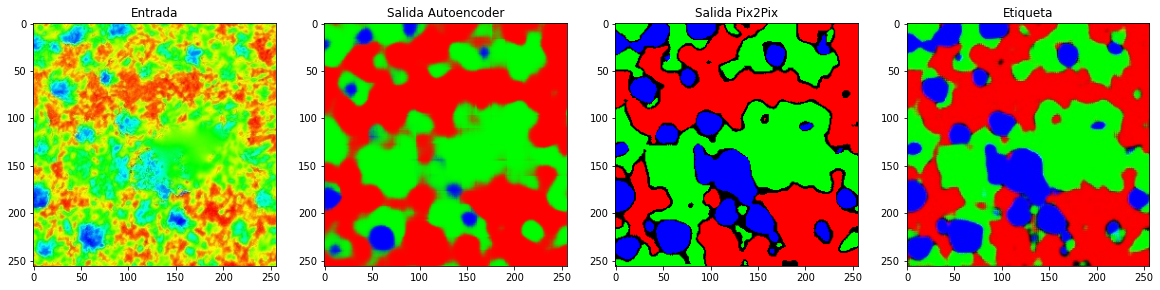

Error MSE:
  *AUC:0.11218310437211691	P2P:0.014080334049485424	P2P_med:0.014080334049485424
Maximos:
  *AUC:0.9999998807907104	P2P:1.0	Label:1.0
Minimos:
  *AUC:7.584386452208491e-09	P2P:-1.0	Label:0.0
0.014080334049485424


In [118]:
plt.figure(figsize=(20,12))

plt.subplot(141)
plt.title('Entrada')
plt.imshow(np.squeeze(entrada)/255)

plt.subplot(142)
plt.title('Salida Autoencoder')
plt.imshow(np.squeeze(auc_p))

plt.subplot(143)
plt.title('Salida Pix2Pix')
plt.imshow(np.squeeze(p2p_p))

plt.subplot(144)
plt.title('Etiqueta')
plt.imshow(np.squeeze(salida)/255)

plt.show()

mse2,ss2 = calcular_metricas_p2p(salida,p2p_p)
mse_auc_1 = metrics.mean_squared_error(np.squeeze(salida)/255,np.squeeze(auc_p))
mse_p2p_1 = metrics.mean_squared_error(np.squeeze(salida)/255,(np.squeeze(p2p_p)+1)/2)
ss_p2p_1 = mse_p2p_1 = metrics.mean_squared_error(np.squeeze(salida)/255,(np.squeeze(p2p_p)+1)/2)
print('Error MSE:\n  *AUC:{}\tP2P:{}\tP2P_med:{}'.format(mse_auc_1,mse_p2p_1,mse2))
print('Maximos:\n  *AUC:{}\tP2P:{}\tLabel:{}'.format(auc_p.max(),p2p_p.max(),np.max(entrada/255)))
print('Minimos:\n  *AUC:{}\tP2P:{}\tLabel:{}'.format(auc_p.min(),p2p_p.min(),np.min(entrada/255)))
print(ss_p2p_1)


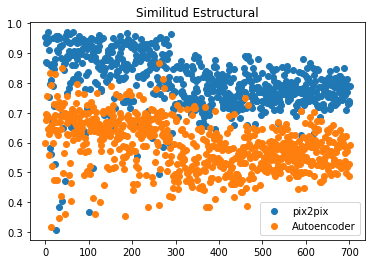

In [119]:
plt.scatter(range(len(ss_auc)),ss_p2p,label='pix2pix')
plt.scatter(range(len(ss_auc)),ss_auc,label='Autoencoder')
plt.legend()
plt.title('Similitud Estructural')
plt.show()

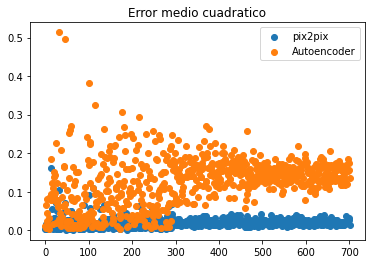

In [120]:
plt.scatter(range(len(ss_auc)),mse_p2p,label='pix2pix')
plt.scatter(range(len(ss_auc)),mse_auc,label='Autoencoder')
plt.legend()
plt.title('Error medio cuadratico')
plt.show()

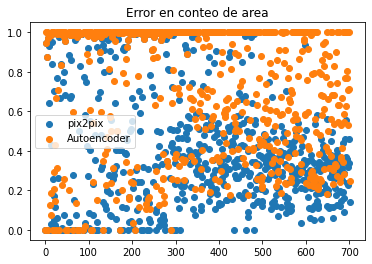

In [121]:
plt.scatter(range(len(ss_auc)),c0_p2p,label='pix2pix')
plt.scatter(range(len(ss_auc)),c0_auc,label='Autoencoder')
plt.legend()
plt.title('Error en conteo de area')
plt.show()

In [131]:
print('*'*50)
print('Pix2Pix ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_p2p)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_p2p)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_p2p)))
print('*'*50)

**************************************************
Pix2Pix ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.5784409358114426
	Area Media (verde):0.9239110894494567
	Area Alta (Roja):0.9372005866378382
**************************************************


In [132]:
print('*'*50)
print('AUTOENCODER ACIERTO MEDIO EN EL CONTEO DE AREAS:')
print('\tArea Baja (azul):{}'.format(1-np.mean(c0_auc)))
print('\tArea Media (verde):{}'.format(1-np.mean(c1_auc)))
print('\tArea Alta (Roja):{}'.format(1-np.mean(c2_auc)))
print('*'*50)

**************************************************
AUTOENCODER ACIERTO MEDIO EN EL CONTEO DE AREAS:
	Area Baja (azul):0.2691095611470742
	Area Media (verde):0.7311570667057397
	Area Alta (Roja):0.5984463870726645
**************************************************
